<a href="https://colab.research.google.com/github/Vani-Kumari/capsuleEndoscopy/blob/main/vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [23]:
# Set Keras backend to JAX
os.environ["KERAS_BACKEND"] = "jax"

In [24]:
# Assuming train_dir and test_dir are paths to your image directories
train_dir = "/content/drive/MyDrive/Capsule Endoscopy Dataset/train_dataset"
test_dir = "/content/drive/MyDrive/Capsule Endoscopy Dataset/Test_Dataset"


In [25]:
batch_size = 32
image_size = (72, 72)  # Adjust based on your dataset

In [26]:
# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

# Load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=image_size,
    batch_size=batch_size
)

Found 4009 files belonging to 8 classes.
Using 3609 files for training.
Found 4009 files belonging to 8 classes.
Using 400 files for validation.
Found 337 files belonging to 8 classes.


In [27]:
# Convert dataset to numpy arrays
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image, label in dataset.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)


In [28]:
print(f"Train dataset: {train_ds}")
print(f"Test dataset: {test_ds}")
print(f"validation dataset: {val_ds}")

Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 72, 72, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 72, 72, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 72, 72, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [29]:
x_train, y_train = dataset_to_numpy(train_ds)
x_test, y_test = dataset_to_numpy(test_ds)
x_val, y_val =dataset_to_numpy(val_ds)

In [30]:
# Configure hyperparameters
num_classes = 8
input_shape = (72, 72, 3)
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 32
num_epochs = 50  # Increase the number of epochs for better training
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 8  # Increase the number of heads in the multi-head attention layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 12  # Increase the number of transformer layers
mlp_head_units = [
    2048,
    1024,
]


In [31]:
# Enhanced data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        layers.RandomContrast(factor=0.2),
        layers.RandomBrightness(factor=0.2),
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

In [32]:
# MLP
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu, kernel_regularizer=keras.regularizers.l2(0.01))(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.BatchNormalization()(x)
    return x


In [33]:
# Patch creation
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

(-0.5, 71.5, 71.5, -0.5)

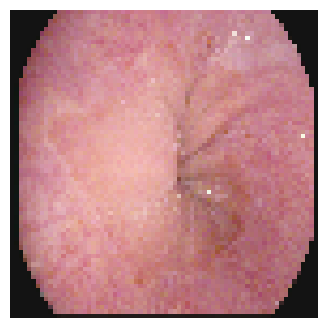

In [34]:

# Display patches for a sample image
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")


In [35]:

resized_image = tf.image.resize(image, size=(image_size, image_size))
patches = Patches(patch_size)(tf.expand_dims(resized_image, 0))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


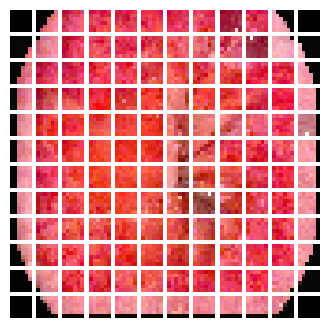

In [36]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(patch_img))
    plt.axis("off")

In [37]:
# Patch encoder
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches, "projection_dim": self.projection_dim})
        return config

In [38]:
# Vision Transformer
def create_vit_classifier():
    inputs = keras.Input(shape=(image_size, image_size, 3))
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [43]:
# Training and evaluation
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    early_stopping_callback = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        restore_best_weights=True
    )

    reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=0.00001
    )

    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=70,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [44]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/70
113/113 [==============================] - 76s 214ms/step - loss: 68.4018 - accuracy: 0.1244 - top-5-accuracy: 0.6101 - val_loss: 65.6481 - val_accuracy: 0.1500 - val_top-5-accuracy: 0.6750 - lr: 1.0000e-04
Epoch 2/70
113/113 [==============================] - 18s 162ms/step - loss: 64.3069 - accuracy: 0.1227 - top-5-accuracy: 0.6243 - val_loss: 61.7941 - val_accuracy: 0.0825 - val_top-5-accuracy: 0.5450 - lr: 1.0000e-04
Epoch 3/70
113/113 [==============================] - 21s 183ms/step - loss: 60.3021 - accuracy: 0.1372 - top-5-accuracy: 0.6381 - val_loss: 57.6754 - val_accuracy: 0.1650 - val_top-5-accuracy: 0.7900 - lr: 1.0000e-04
Epoch 4/70
113/113 [==============================] - 18s 162ms/step - loss: 56.5295 - accuracy: 0.1330 - top-5-accuracy: 0.6243 - val_loss: 54.0453 - val_accuracy: 0.1625 - val_top-5-accuracy: 0.7575 - lr: 1.0000e-04
Epoch 5/70
113/113 [==============================] - 19s 164ms/step - loss: 52.9111 - accuracy: 0.1297 - top-5-accuracy: 0.6434

In [45]:
# Plotting
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

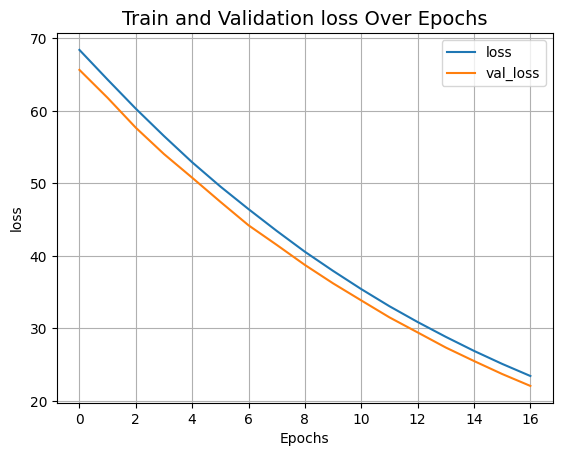

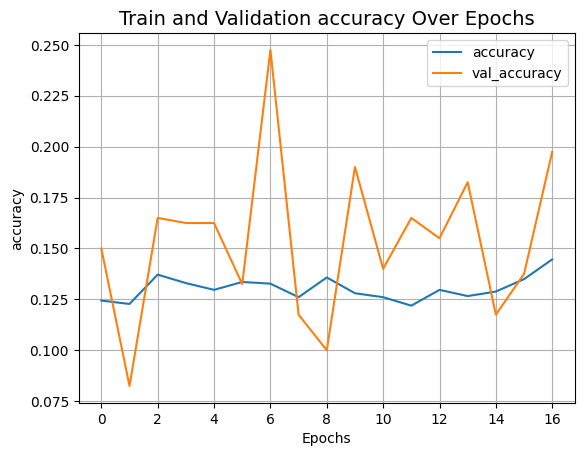

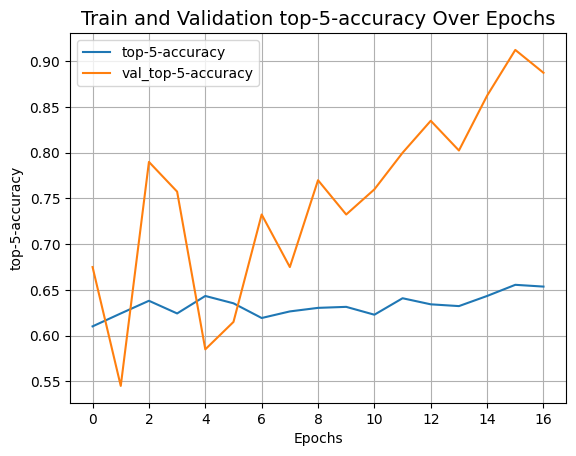

In [46]:
plot_history("loss")
plot_history("accuracy")
plot_history("top-5-accuracy")